In [54]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt  
plt.rcParams["figure.figsize"] = (1200, 1200)#set default figure size
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as s
import statsmodels.regression.linear_model as rg
import statsmodels.tools.tools as ct
import statsmodels.stats.diagnostic as dg
sns.set(rc = {'figure.figsize':(12,12)})
import math
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import IV2SLS
import statsmodels.stats.outliers_influence as oi
from collections import OrderedDict
from linearmodels.iv.results import compare
from statsmodels.stats.outliers_influence import variance_inflation_factor

Устанавливаю необходимые библиотеки

In [55]:
pip install linearmodels

Note: you may need to restart the kernel to use updated packages.


Ставлю рабочую директорию

In [56]:
os.chdir('/Users/olgakalinina/Downloads/')

Загружаю данные

In [57]:
file ='diplom.xlsx'
data = pd.read_excel("diplom.xlsx",engine='openpyxl') 
d3=data.iloc[:400]

Делаю предобработку данных

In [58]:
d3['const']=1
d3['dens_1km2_ln']=np.log1p(d3['density_thousandpeople_1km2'])
d3['grp_per_person_10000euro']=d3['grp_per_person_10000euro']*1000
d3['disposable_income_per_capita_10000euro']=d3['disposable_income_per_capita_10000euro']*1000
d3['grp_ln']=np.log1p(d3['grp_per_person_10000euro'])
d3['income_ln']=np.log1p(d3['disposable_income_per_capita_10000euro'])
#d3['average_age_ln']=np.log1p(d3['average_age'])
d3['postmet_index_ln']=np.log1p(d3['postmetrialism_index'])
d3['healthcare_ln']=np.log1p(d3['healthcare_overall'])
d3['age_more_65_ln']=np.log1p(d3['age_more_65'])
d3['cases_rate_ln']=np.log1p(d3['cases_rate'])
d3['afd_ln']=np.log1p(d3['afd_2017'])
d3['green_ln']=np.log1p(d3['green'])
d3['vaccine_3_ln']=np.log1p(d3['vaccine_3'])
d3['d_rate_ln']=np.log1p(d3['death_rate'])
d3['trust_ln']=np.log1p(d3['trust'])
d3['activity_ln']=np.log1p(d3['activity'])
d3['politics_ln']=np.log1p(d3['politics'])
d3['TV_ln']=np.log1p(d3['western_TV'])
d3['green_ln']=np.log1p(d3['green'])
d3['unemployment_2019_ln']=np.log1p(d3['unemployment_2019'])
d3['vaccine_2_ln']=np.log1p(d3['vaccine_2'])
d3['const']=1
d3['postm_ind_ln']=np.log1p(d3['postmetrialism_index_final'])
d3['vacc_c_ln']=np.log1p(d3['vacc_centres_rate'])
d3['summer_temp_ln']=np.log1p(d3['summer_temp'])
d3['winter_temp_ln']=np.log1p(d3['winter_temp'])
d3=d3.rename(columns={'postmetrialism_index_final': 'social_capital'})
d3=d3.rename(columns={'postm_index_new': 'social_capital_with_afd'})

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

Строю корреляционную матрицу и сохраняю

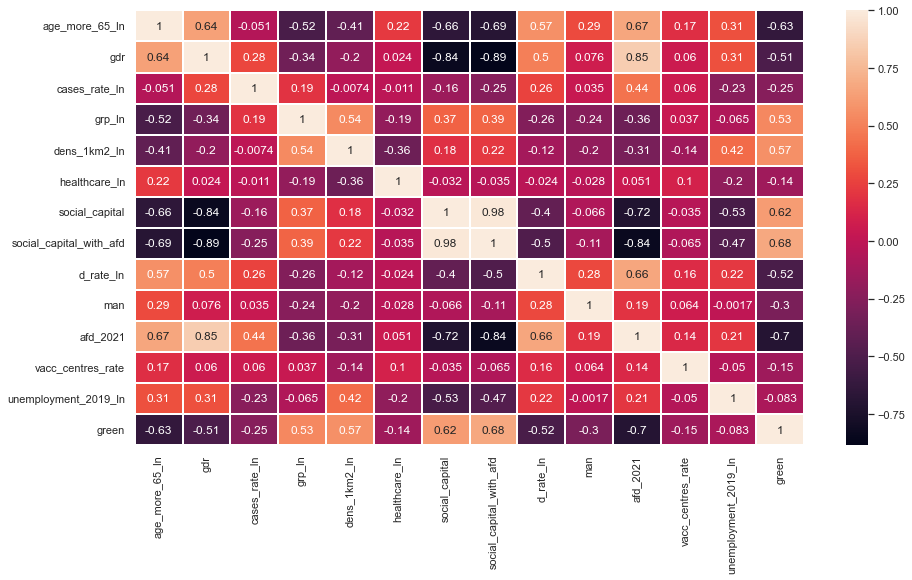

In [59]:
corrMatrix = d3[['age_more_65_ln', 'gdr','cases_rate_ln', 'grp_ln', 'dens_1km2_ln', 'healthcare_ln', 'social_capital', 'social_capital_with_afd', 'd_rate_ln',  'man', 'afd_2021', 'vacc_centres_rate', 'unemployment_2019_ln', 'green']].corr()
fig, ax = plt.subplots(figsize=(15,8)) 
sns.heatmap(corrMatrix, annot=True, linewidths=.110, ax=ax)
#plt.savefig('pic55.png', dpi=2000)
plt.show()

Создадим необходимые функции:

- функция vif выводит таблицу с значениями VIF для заданных переменных

- функция twomnk строит 2МНК

- функция ramsey выводит p-value теста Рамсея для модели

- функция relevant проверяет релевантность инструмента, выбранного для двухшагового МНК

- функция hausman проводит тест Хаусмана для модели и определяет, как нужно строить модель, используя МНК или 2МНК

- функция sargan проводит тест Саргана и проверяет инструменты на экзогенность

- функция extramnk строит МНК модель

In [60]:
def vif (data, X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
    print(vif_data)
    
def twomnk (data, exog, endog, instr, y):
    res = OrderedDict()
    for i in range(1,len(instr)+1):
        reg=IV2SLS(data[y], data[exog], data[endog], data[instr[i-1]]).fit(cov_type="robust")
        res[str(i)]=reg
    print(compare(res, stars=True, precision='std_errors'))

def ramsey (data, endog, exog, instr, y):
    for i in range(1, len(instr) + 1):
        ols_support=sm.OLS(d3[endog], d3[exog+instr[i-1]]).fit(cov_type="HC3")
        d3['endog_new']=ols_support.predict(d3[exog+instr[i-1]])
        endog_predicted=['endog_new']
        reg= sm.OLS(d3[y], d3[exog+endog_predicted]).fit(cov_type="HC3")
    print("В модели " + str(i) + " " + str(oi.reset_ramsey(reg, degree = 4))[30:60])

def relevant(data, exog, endog, instr):
    for i in range(1, len(instr)+1):
        X=exog+instr[i-1]
        with_instr = sm.OLS(data[endog], data[X]).fit(cov_type='HC3')
        without_instr = sm.OLS(data[endog], data[exog]).fit(cov_type='HC3')
        print((((with_instr.rsquared)-without_instr.rsquared)/(1-with_instr.rsquared))*((len(data)-(len(exog)-1))/len(instr[i-1])))
        if ((((with_instr.rsquared)-without_instr.rsquared)/(1-with_instr.rsquared))*((len(data)-(len(exog)-1))/len(instr[i-1])) < 10):
            print("Инструмент " + str(instr[i - 1]) + " в модели " + str(i) + " нерелевантный")
        else:
            print("Инструмент " + str(instr[i - 1]) + " в модели " + str(i) + " релевантный")
            
def hausman (data, exog, endog, instr, y):
    for i in range(1,len(instr)+1):
        reg=IV2SLS(data[y], data[exog], data[endog], data[instr[i-1]]).fit(cov_type="robust")
        print(reg.wu_hausman().pval)
        if (reg.wu_hausman().pval > 0.01):
            print("Для модели " + str(i) + " МНК-оценки лучше")
        else:
            print("Для модели " + str(i) + " 2МНК-оценки лучше")
    
def sargan(data, exog, endog, instr, y):
    for i in range(1, len(instr)+1):
        reg=IV2SLS(data[y], data[exog], data[endog], data[instr[i-1]]).fit(cov_type="robust")
        print(reg.sargan.pval)
        if (len(instr[i-1]) > 1):
            if (reg.sargan.pval > 0.01):
                print("В модели " + str(i) + " все инструменты экзогенные")
            else:
                print("В модели " + str(i) + " хоть какой-то инструмент эндогенен")
            
def extramnk (data, base, extra, endog, instr, y):
    res = OrderedDict()
    X=base
    for i in range(1,len(extra)+1):
        X+=extra[i-1]
        reg=IV2SLS(data[y], data[X], data[endog], data[instr]).fit(cov_type="robust")
        res[str(i)]=reg
    print(compare(res, stars=True, precision='std_errors'))

Построим 1МНК-модель, где зависимая переменная - уровень смертности, и проведем тест Рамсея

In [61]:
y=['d_rate_ln']
exog =['gdr', 'healthcare_ln', 'dens_1km2_ln', 'winter_temp_ln', 'age_more_65_ln', 'grp_ln', 'man']
endog= ['vaccine_3_ln']
instr1=['social_capital']
instr2=['afd_ln']
instr3=['afd_ln', 'social_capital']
instr4=['cases_rate_ln', 'postm_ind_ln']
instr5=['cases_rate_ln', 'afd_ln', 'social_capital']
instr=[]

In [62]:
reg= sm.OLS(d3[y], d3[exog+endog]).fit(cov_type="HC3")
result_table= summary_col(results = reg, stars = True)
print(result_table)
print(str(oi.reset_ramsey(reg, degree = 4))[30:55])


               d_rate_ln 
-------------------------
gdr            0.0826*** 
               (0.0253)  
healthcare_ln  -0.1633** 
               (0.0716)  
dens_1km2_ln   0.0872*** 
               (0.0210)  
winter_temp_ln -0.0234***
               (0.0041)  
age_more_65_ln 3.3681*** 
               (0.3921)  
grp_ln         -0.0470***
               (0.0097)  
man            0.5342*** 
               (0.1560)  
vaccine_3_ln   -0.1498***
               (0.0556)  
R-squared      0.9506    
R-squared Adj. 0.9496    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01
=0.004503364865091184, df


P-value теста Рамсея < 0.01 => не отвергаем гипотезу о том, что модель специфицирована неверно

In [63]:
#instr.append(instr1)
instr.append(instr2)
instr.append(instr3)
#instr.append(instr4)
#instr.append(instr5)

Посмотрим на описательную статистику переменных для модели, где зависимая переменная - уровень смертности

In [64]:
d4 = d3[['healthcare_ln', 'dens_1km2_ln',  'age_more_65_ln', 'grp_ln',  'gdr', 'vaccine_3_ln', 'd_rate_ln', 'afd_ln', 'man']]

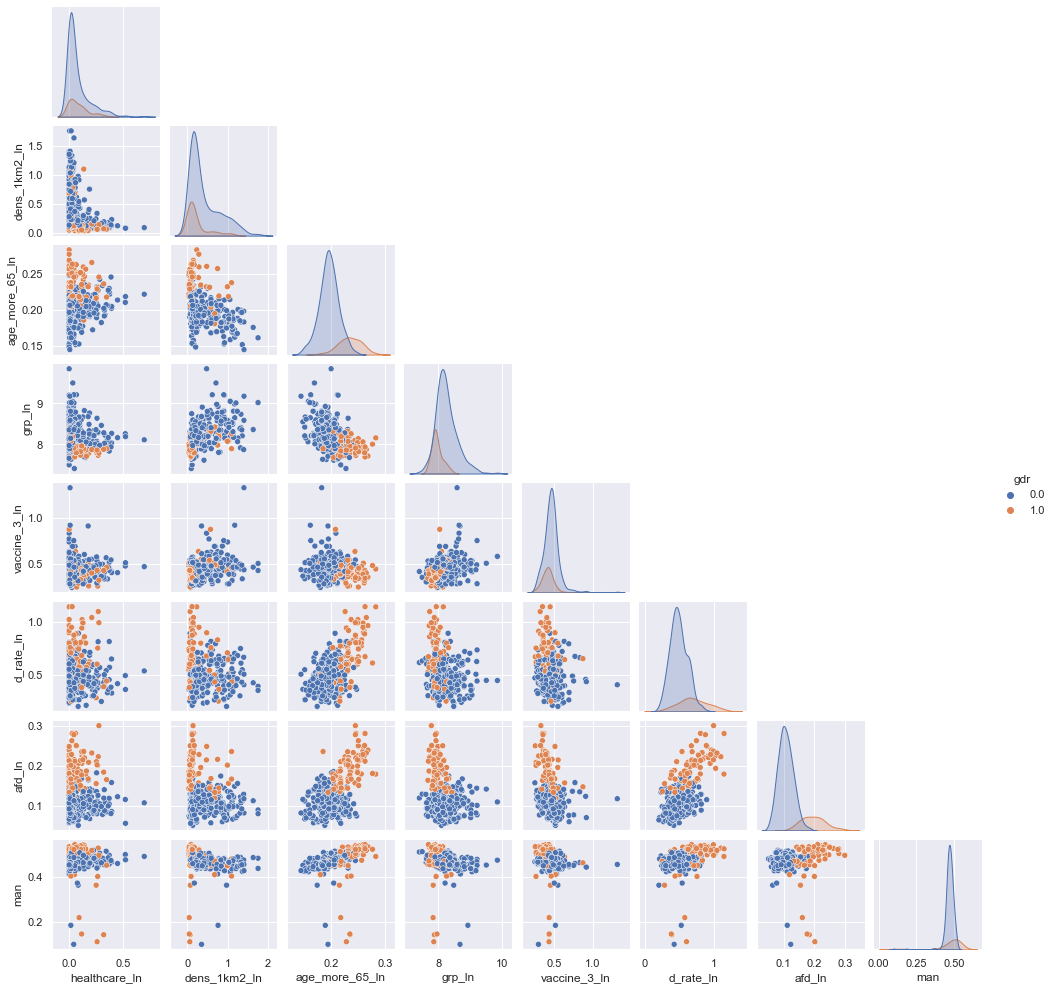

In [65]:
sns.pairplot(d4, hue="gdr", height=1.75, corner=True)
#plt.savefig('pic50.png', dpi=2700)

Находим VIF для зависимых переменных (чтобы определить мультиколлениарность) и строим 2МНК

In [66]:
vif(d3, d3[exog + endog])

          feature         VIF
0             gdr    2.269986
1   healthcare_ln    1.885356
2    dens_1km2_ln    3.352450
3  winter_temp_ln    1.191947
4  age_more_65_ln  147.973836
5          grp_ln  166.496204
6             man  106.552597
7    vaccine_3_ln   23.383789


В данных VIF > 10 => присутствует строгая мультиколлениарность, но в корреляционной таблице нет корреляции больше 0.9, то есть по критерию корреляции строгой мультиколлинеарности нет, а по критерию VIF – есть. Тем не менее мультиколлинеарность сама по себе не вызывает смещения и бороться с ней нужно, если она приводит к существенным проблемам (например, к огромным стандартным ошибкам оценок коэффициентов или заведомой неадекватности полученных результатов). Во всех остальных случаях данную проблему можно игнорировать.  В моем случае стандартные ошибки не влияют на знак объясняющей переменной (интервалы не содержат 0), и результаты соответствуют результатам предыдущих исследований. 

In [67]:
twomnk(d3, exog, endog, instr, y)

                  Model Comparison                  
                                  1                2
----------------------------------------------------
Dep. Variable             d_rate_ln        d_rate_ln
Estimator                   IV-2SLS          IV-2SLS
No. Observations                400              400
Cov. Est.                    robust           robust
R-squared                    0.8772           0.8850
Adj. R-squared               0.8747           0.8827
F-statistic                  3926.9           4094.9
P-value (F-stat)             0.0000           0.0000
==================     ============     ============
gdr                         -0.0048         2.09e-05
                           (0.0425)         (0.0388)
healthcare_ln              -0.1772*         -0.1765*
                           (0.0933)         (0.0909)
dens_1km2_ln              0.2014***        0.1951***
                           (0.0477)         (0.0460)
winter_temp_ln            -0.0182**       -0.0

Провожу тест Рамсея, тест Хаусмана, тест Саргана, тест на проверку релевантности инструментов 

In [68]:
y=['d_rate_ln']
exog =['gdr', 'healthcare_ln', 'dens_1km2_ln', 'winter_temp_ln', 'age_more_65_ln', 'grp_ln', 'man']
endog= ['vaccine_3_ln']
instr1=['social_capital']
instr2=['afd_ln']
instr3=['afd_ln', 'social_capital']
instr4=['cases_rate_ln', 'postm_ind_ln']
instr5=['cases_rate_ln', 'afd_ln', 'social_capital']
instr=[]
instr.append(instr2)
ramsey(d3, endog, exog, instr, y)
instr.append(instr3)
ramsey(d3, endog, exog, instr, y)

В модели 1 p=0.042556501841537295, df_den
В модели 2 p=0.028660053744795366, df_den


In [69]:
relevant(d3, exog, endog, instr)

38.31722907334863
Инструмент ['afd_ln'] в модели 1 релевантный
22.049351111888956
Инструмент ['afd_ln', 'social_capital'] в модели 2 релевантный


In [70]:
hausman(d3, exog, endog, instr, y)

5.551115123125783e-15
Для модели 1 2МНК-оценки лучше
1.1102230246251565e-15
Для модели 2 2МНК-оценки лучше


In [71]:
sargan(d3, exog, endog, instr, y)

nan
0.45027027891482185
В модели 2 все инструменты экзогенные


Все проверки модели прошли

Перед тем, как строить 1МНК-модель, где зависимая переменная - уровень вакцинации, посмотрим на описательную статистику переменных

In [72]:
d5=d3[["vaccine_3_ln", "gdr", "afd_ln", "grp_ln", "unemployment_2019_ln", "vacc_centres_rate", "social_capital_with_afd", "social_capital", "green", "airport"]]

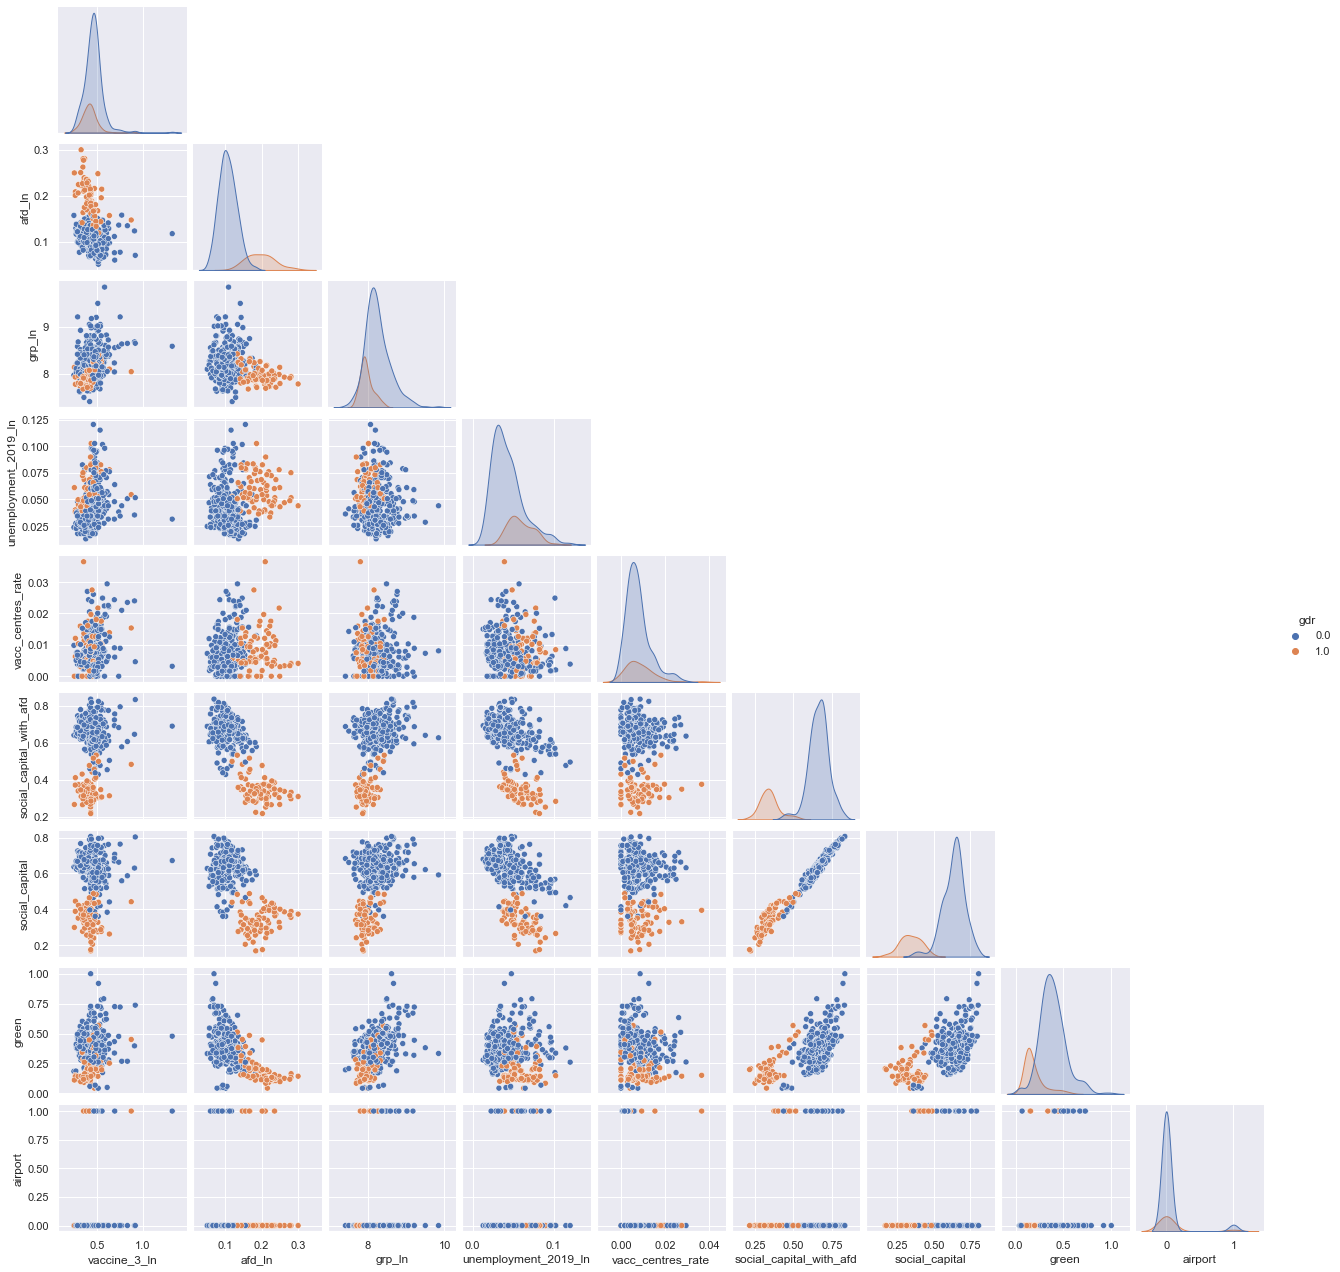

In [73]:
sns.pairplot(d5, hue="gdr", height=2, corner=True)
#plt.savefig('pic31.png', dpi=2000)

In [74]:
mod11v='vaccine_3_ln ~  vacc_centres_rate + afd_ln  + grp_ln  + unemployment_2019_ln - 1'
reg11v = IV2SLS.from_formula(mod11v,d3).fit(cov_type="robust")
mod55v='vaccine_3_ln ~  vacc_centres_rate + green  + grp_ln + unemployment_2019_ln  - 1'
reg55v = IV2SLS.from_formula(mod55v,d3).fit(cov_type="robust")
mod33v='vaccine_3_ln ~  vacc_centres_rate + social_capital_with_afd  + grp_ln   + unemployment_2019_ln  - 1'
reg33v = IV2SLS.from_formula(mod33v,d3).fit(cov_type="robust")
mod22v='vaccine_3_ln ~  vacc_centres_rate + afd_ln + grp_ln  - 1'
reg22v = IV2SLS.from_formula(mod22v,d3).fit(cov_type="robust")
mod44v='vaccine_3_ln ~  vacc_centres_rate + social_capital + grp_ln   + unemployment_2019_ln  - 1'
reg44v = IV2SLS.from_formula(mod44v,d3).fit(cov_type="robust")

res1v = OrderedDict()
res1v["1"] = reg11v
res1v["2"] = reg22v
res1v["3"] = reg33v
res1v["4"] = reg44v
result = compare(res1v, stars=True, precision='std_errors')
print(result)

                                   Model Comparison                                  
                                       1              2              3              4
-------------------------------------------------------------------------------------
Dep. Variable               vaccine_3_ln   vaccine_3_ln   vaccine_3_ln   vaccine_3_ln
Estimator                            OLS            OLS            OLS            OLS
No. Observations                     400            400            400            400
Cov. Est.                         robust         robust         robust         robust
R-squared                         0.9634         0.9598         0.9600         0.9589
Adj. R-squared                    0.9630         0.9595         0.9596         0.9585
F-statistic                    1.242e+04         9177.6      1.095e+04      1.064e+04
P-value (F-stat)                  0.0000         0.0000         0.0000         0.0000
========================= ============== =============

Проведем тесты Рамсея для полученных моделей, чтобы не отвергнуть гипотезу о верной спецификации модели

In [75]:
y=d3[['vaccine_3_ln']]
x1=d3[['grp_ln', 'vacc_centres_rate', 'unemployment_2019_ln', 'afd_ln']]
reg = sm.OLS(y, x1).fit(cov_type="HC3")
print(str(oi.reset_ramsey(reg, degree = 4))[30:55])

 p=0.054447531648918274, 


In [76]:
y=d3[['vaccine_3_ln']]
x1=d3[['grp_ln', 'vacc_centres_rate',  'afd_ln']]
reg = sm.OLS(y, x1).fit(cov_type="HC3")
print(str(oi.reset_ramsey(reg, degree = 4))[30:55])

p=0.10779898229184848, df


In [77]:
y=d3[['vaccine_3_ln']]
x1=d3[['grp_ln', 'vacc_centres_rate', 'unemployment_2019_ln',  'social_capital_with_afd']]
reg = sm.OLS(y, x1).fit(cov_type="HC3")
print(str(oi.reset_ramsey(reg, degree = 4))[30:55])

p=0.04223154497242994, df


In [78]:
y=d3[['vaccine_3_ln']]
x1=d3[['grp_ln', 'vacc_centres_rate', 'unemployment_2019_ln',   'social_capital']]
reg = sm.OLS(y, x1).fit(cov_type="HC3")
print(str(oi.reset_ramsey(reg, degree = 4))[30:55])

p=0.05145953146317472, df


P-value теста Рамсея < 0.01 => не отвергаем гипотезу о том, что модель специфицирована неверно